In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 aloss:0.7138 eloss:3.2273 aloss2:2.1535 exploreP:0.9980
Episode:1 meanR:19.5000 R:19.0000 rate:0.0380 aloss:0.7169 eloss:3.2426 aloss2:2.1387 exploreP:0.9961
Episode:2 meanR:28.3333 R:46.0000 rate:0.0920 aloss:0.7105 eloss:3.2056 aloss2:2.1689 exploreP:0.9916
Episode:3 meanR:30.7500 R:38.0000 rate:0.0760 aloss:0.7082 eloss:3.2091 aloss2:2.1699 exploreP:0.9879
Episode:4 meanR:27.8000 R:16.0000 rate:0.0320 aloss:0.7087 eloss:3.1901 aloss2:2.1873 exploreP:0.9863
Episode:5 meanR:25.6667 R:15.0000 rate:0.0300 aloss:0.7079 eloss:3.2234 aloss2:2.1494 exploreP:0.9849
Episode:6 meanR:24.4286 R:17.0000 rate:0.0340 aloss:0.7000 eloss:3.1845 aloss2:2.1891 exploreP:0.9832
Episode:7 meanR:29.7500 R:67.0000 rate:0.1340 aloss:0.7007 eloss:3.1972 aloss2:2.1849 exploreP:0.9767
Episode:8 meanR:28.0000 R:14.0000 rate:0.0280 aloss:0.7011 eloss:3.1853 aloss2:2.1885 exploreP:0.9754
Episode:9 meanR:27.0000 R:18.0000 rate:0.0360 aloss:0.7038 eloss:3.2135 aloss2:2.1

Episode:80 meanR:24.3210 R:17.0000 rate:0.0340 aloss:0.6771 eloss:3.3031 aloss2:2.2427 exploreP:0.8230
Episode:81 meanR:24.1707 R:12.0000 rate:0.0240 aloss:0.6810 eloss:3.3023 aloss2:2.2495 exploreP:0.8220
Episode:82 meanR:24.1446 R:22.0000 rate:0.0440 aloss:0.6793 eloss:3.2638 aloss2:2.2695 exploreP:0.8202
Episode:83 meanR:23.9643 R:9.0000 rate:0.0180 aloss:0.6762 eloss:3.2111 aloss2:2.2709 exploreP:0.8195
Episode:84 meanR:24.1412 R:39.0000 rate:0.0780 aloss:0.6888 eloss:3.2436 aloss2:2.2863 exploreP:0.8163
Episode:85 meanR:24.3256 R:40.0000 rate:0.0800 aloss:0.6753 eloss:3.2182 aloss2:2.3158 exploreP:0.8131
Episode:86 meanR:24.2529 R:18.0000 rate:0.0360 aloss:0.6726 eloss:3.1895 aloss2:2.3327 exploreP:0.8117
Episode:87 meanR:24.1705 R:17.0000 rate:0.0340 aloss:0.6749 eloss:3.2070 aloss2:2.3257 exploreP:0.8103
Episode:88 meanR:24.2360 R:30.0000 rate:0.0600 aloss:0.6756 eloss:3.2021 aloss2:2.3351 exploreP:0.8079
Episode:89 meanR:24.1111 R:13.0000 rate:0.0260 aloss:0.6722 eloss:3.2420 a

Episode:159 meanR:25.4700 R:11.0000 rate:0.0220 aloss:0.7684 eloss:3.9850 aloss2:1.9514 exploreP:0.6812
Episode:160 meanR:25.5000 R:17.0000 rate:0.0340 aloss:0.7565 eloss:4.0229 aloss2:1.9353 exploreP:0.6800
Episode:161 meanR:25.4800 R:16.0000 rate:0.0320 aloss:0.7467 eloss:3.9793 aloss2:1.9846 exploreP:0.6789
Episode:162 meanR:25.2700 R:11.0000 rate:0.0220 aloss:0.7223 eloss:3.8412 aloss2:2.0602 exploreP:0.6782
Episode:163 meanR:25.4700 R:37.0000 rate:0.0740 aloss:0.7288 eloss:4.0641 aloss2:1.9170 exploreP:0.6757
Episode:164 meanR:25.4600 R:21.0000 rate:0.0420 aloss:0.7115 eloss:4.0290 aloss2:1.9491 exploreP:0.6743
Episode:165 meanR:25.2700 R:12.0000 rate:0.0240 aloss:0.7236 eloss:4.0966 aloss2:1.9092 exploreP:0.6736
Episode:166 meanR:25.2400 R:13.0000 rate:0.0260 aloss:0.7007 eloss:4.0873 aloss2:1.9118 exploreP:0.6727
Episode:167 meanR:25.1600 R:26.0000 rate:0.0520 aloss:0.7179 eloss:4.1417 aloss2:1.8804 exploreP:0.6710
Episode:168 meanR:24.9100 R:11.0000 rate:0.0220 aloss:0.7061 elo

Episode:238 meanR:47.8300 R:222.0000 rate:0.4440 aloss:0.6856 eloss:3.3491 aloss2:2.3678 exploreP:0.4422
Episode:239 meanR:50.6800 R:300.0000 rate:0.6000 aloss:0.6925 eloss:3.3433 aloss2:2.3698 exploreP:0.4294
Episode:240 meanR:52.7700 R:233.0000 rate:0.4660 aloss:0.6948 eloss:3.3319 aloss2:2.3737 exploreP:0.4197
Episode:241 meanR:54.2100 R:159.0000 rate:0.3180 aloss:0.6919 eloss:3.3179 aloss2:2.3696 exploreP:0.4133
Episode:242 meanR:54.6300 R:94.0000 rate:0.1880 aloss:0.7121 eloss:3.3210 aloss2:2.3670 exploreP:0.4095
Episode:243 meanR:57.4400 R:323.0000 rate:0.6460 aloss:0.6866 eloss:3.3101 aloss2:2.3627 exploreP:0.3968
Episode:244 meanR:61.1900 R:390.0000 rate:0.7800 aloss:0.6987 eloss:3.3074 aloss2:2.3669 exploreP:0.3820
Episode:245 meanR:66.0500 R:500.0000 rate:1.0000 aloss:0.6834 eloss:3.3023 aloss2:2.3698 exploreP:0.3639
Episode:246 meanR:70.2000 R:425.0000 rate:0.8500 aloss:0.6868 eloss:3.3044 aloss2:2.3598 exploreP:0.3491
Episode:247 meanR:75.0700 R:500.0000 rate:1.0000 aloss:0

Episode:317 meanR:150.0500 R:11.0000 rate:0.0220 aloss:0.7716 eloss:3.2609 aloss2:2.1532 exploreP:0.1315
Episode:318 meanR:149.8100 R:9.0000 rate:0.0180 aloss:0.8441 eloss:3.2942 aloss2:2.1093 exploreP:0.1314
Episode:319 meanR:149.6600 R:9.0000 rate:0.0180 aloss:0.7294 eloss:3.3113 aloss2:2.1082 exploreP:0.1313
Episode:320 meanR:149.4100 R:9.0000 rate:0.0180 aloss:0.7855 eloss:3.2545 aloss2:2.1528 exploreP:0.1312
Episode:321 meanR:149.2600 R:10.0000 rate:0.0200 aloss:0.7554 eloss:3.1884 aloss2:2.1526 exploreP:0.1311
Episode:322 meanR:149.1100 R:10.0000 rate:0.0200 aloss:0.7654 eloss:3.2448 aloss2:2.1601 exploreP:0.1309
Episode:323 meanR:147.8200 R:10.0000 rate:0.0200 aloss:0.7977 eloss:3.2152 aloss2:2.1740 exploreP:0.1308
Episode:324 meanR:146.9600 R:8.0000 rate:0.0160 aloss:0.7435 eloss:3.2127 aloss2:2.1561 exploreP:0.1307
Episode:325 meanR:144.2500 R:9.0000 rate:0.0180 aloss:0.8449 eloss:3.2762 aloss2:2.1508 exploreP:0.1306
Episode:326 meanR:143.6600 R:11.0000 rate:0.0220 aloss:0.835

Episode:396 meanR:9.9400 R:10.0000 rate:0.0200 aloss:0.7293 eloss:3.0766 aloss2:2.3104 exploreP:0.1224
Episode:397 meanR:9.9200 R:10.0000 rate:0.0200 aloss:0.7343 eloss:3.0802 aloss2:2.3079 exploreP:0.1223
Episode:398 meanR:9.9200 R:10.0000 rate:0.0200 aloss:0.7287 eloss:3.1072 aloss2:2.2969 exploreP:0.1222
Episode:399 meanR:9.9100 R:10.0000 rate:0.0200 aloss:0.7441 eloss:3.0812 aloss2:2.2949 exploreP:0.1221
Episode:400 meanR:9.9100 R:9.0000 rate:0.0180 aloss:0.7406 eloss:3.0390 aloss2:2.3007 exploreP:0.1220
Episode:401 meanR:9.9000 R:10.0000 rate:0.0200 aloss:0.7223 eloss:3.1180 aloss2:2.2810 exploreP:0.1218
Episode:402 meanR:9.9000 R:10.0000 rate:0.0200 aloss:0.6950 eloss:3.0441 aloss2:2.2951 exploreP:0.1217
Episode:403 meanR:9.8800 R:10.0000 rate:0.0200 aloss:0.6918 eloss:3.0657 aloss2:2.2779 exploreP:0.1216
Episode:404 meanR:9.8600 R:9.0000 rate:0.0180 aloss:0.7294 eloss:3.1125 aloss2:2.2679 exploreP:0.1215
Episode:405 meanR:9.8700 R:10.0000 rate:0.0200 aloss:0.7490 eloss:3.1322 al

Episode:474 meanR:160.7500 R:160.0000 rate:0.3200 aloss:0.7258 eloss:3.2008 aloss2:2.2027 exploreP:0.0330
Episode:475 meanR:162.2500 R:160.0000 rate:0.3200 aloss:0.7182 eloss:3.2121 aloss2:2.2152 exploreP:0.0327
Episode:476 meanR:163.4600 R:131.0000 rate:0.2620 aloss:0.7276 eloss:3.2229 aloss2:2.2111 exploreP:0.0324
Episode:477 meanR:164.7500 R:139.0000 rate:0.2780 aloss:0.6959 eloss:3.2226 aloss2:2.2272 exploreP:0.0320
Episode:478 meanR:166.2400 R:158.0000 rate:0.3160 aloss:0.6845 eloss:3.1957 aloss2:2.2448 exploreP:0.0317
Episode:479 meanR:167.4200 R:126.0000 rate:0.2520 aloss:0.6841 eloss:3.1977 aloss2:2.2434 exploreP:0.0314
Episode:480 meanR:168.9900 R:166.0000 rate:0.3320 aloss:0.6730 eloss:3.2243 aloss2:2.2194 exploreP:0.0311
Episode:481 meanR:169.1200 R:23.0000 rate:0.0460 aloss:0.6851 eloss:3.2880 aloss2:2.1702 exploreP:0.0310
Episode:482 meanR:169.1700 R:16.0000 rate:0.0320 aloss:0.7084 eloss:3.2566 aloss2:2.1945 exploreP:0.0310
Episode:483 meanR:169.3300 R:25.0000 rate:0.0500

Episode:553 meanR:65.8400 R:10.0000 rate:0.0200 aloss:0.7063 eloss:3.2068 aloss2:2.1718 exploreP:0.0290
Episode:554 meanR:63.3300 R:10.0000 rate:0.0200 aloss:0.7112 eloss:3.2293 aloss2:2.1872 exploreP:0.0290
Episode:555 meanR:61.9300 R:9.0000 rate:0.0180 aloss:0.7217 eloss:3.2482 aloss2:2.1885 exploreP:0.0290
Episode:556 meanR:61.1500 R:9.0000 rate:0.0180 aloss:0.7220 eloss:3.3470 aloss2:2.1393 exploreP:0.0290
Episode:557 meanR:59.9800 R:8.0000 rate:0.0160 aloss:0.7177 eloss:3.3752 aloss2:2.1358 exploreP:0.0289
Episode:558 meanR:58.9800 R:10.0000 rate:0.0200 aloss:0.7198 eloss:3.1448 aloss2:2.2155 exploreP:0.0289
Episode:559 meanR:57.9900 R:11.0000 rate:0.0220 aloss:0.7158 eloss:3.3444 aloss2:2.1509 exploreP:0.0289
Episode:560 meanR:55.6300 R:8.0000 rate:0.0160 aloss:0.7109 eloss:3.3487 aloss2:2.1558 exploreP:0.0289
Episode:561 meanR:54.4300 R:10.0000 rate:0.0200 aloss:0.7427 eloss:3.2499 aloss2:2.1835 exploreP:0.0289
Episode:562 meanR:49.5300 R:10.0000 rate:0.0200 aloss:0.7522 eloss:3

Episode:633 meanR:9.4800 R:10.0000 rate:0.0200 aloss:0.7310 eloss:3.1196 aloss2:2.2147 exploreP:0.0276
Episode:634 meanR:9.4900 R:10.0000 rate:0.0200 aloss:0.7337 eloss:3.0906 aloss2:2.2157 exploreP:0.0276
Episode:635 meanR:9.5000 R:10.0000 rate:0.0200 aloss:0.7475 eloss:3.1709 aloss2:2.2101 exploreP:0.0276
Episode:636 meanR:9.5100 R:10.0000 rate:0.0200 aloss:0.7465 eloss:3.1856 aloss2:2.1942 exploreP:0.0276
Episode:637 meanR:9.5000 R:8.0000 rate:0.0160 aloss:0.7297 eloss:3.0585 aloss2:2.2094 exploreP:0.0276
Episode:638 meanR:9.5100 R:11.0000 rate:0.0220 aloss:0.7282 eloss:3.1696 aloss2:2.2242 exploreP:0.0275
Episode:639 meanR:9.4900 R:9.0000 rate:0.0180 aloss:0.7550 eloss:3.1607 aloss2:2.2136 exploreP:0.0275
Episode:640 meanR:9.4900 R:9.0000 rate:0.0180 aloss:0.7647 eloss:3.1950 aloss2:2.1895 exploreP:0.0275
Episode:641 meanR:9.4800 R:10.0000 rate:0.0200 aloss:0.7436 eloss:3.1239 aloss2:2.2216 exploreP:0.0275
Episode:642 meanR:9.4600 R:9.0000 rate:0.0180 aloss:0.7367 eloss:3.0742 alos

Episode:713 meanR:9.5300 R:9.0000 rate:0.0180 aloss:0.7436 eloss:3.0238 aloss2:2.2112 exploreP:0.0263
Episode:714 meanR:9.5400 R:10.0000 rate:0.0200 aloss:0.7337 eloss:3.1009 aloss2:2.2356 exploreP:0.0263
Episode:715 meanR:9.5300 R:9.0000 rate:0.0180 aloss:0.7104 eloss:3.1658 aloss2:2.2542 exploreP:0.0263
Episode:716 meanR:9.5500 R:10.0000 rate:0.0200 aloss:0.7084 eloss:3.0992 aloss2:2.2428 exploreP:0.0263
Episode:717 meanR:9.5400 R:8.0000 rate:0.0160 aloss:0.7505 eloss:3.1067 aloss2:2.2451 exploreP:0.0263
Episode:718 meanR:9.5500 R:10.0000 rate:0.0200 aloss:0.7396 eloss:3.0675 aloss2:2.2353 exploreP:0.0263
Episode:719 meanR:9.5400 R:8.0000 rate:0.0160 aloss:0.7409 eloss:3.0917 aloss2:2.2659 exploreP:0.0262
Episode:720 meanR:9.5300 R:9.0000 rate:0.0180 aloss:0.7249 eloss:3.0940 aloss2:2.2523 exploreP:0.0262
Episode:721 meanR:9.5400 R:10.0000 rate:0.0200 aloss:0.7275 eloss:3.0459 aloss2:2.2265 exploreP:0.0262
Episode:722 meanR:9.5200 R:8.0000 rate:0.0160 aloss:0.7536 eloss:3.0837 aloss2

Episode:793 meanR:9.5500 R:9.0000 rate:0.0180 aloss:0.6782 eloss:3.0494 aloss2:2.2342 exploreP:0.0251
Episode:794 meanR:9.5600 R:11.0000 rate:0.0220 aloss:0.7187 eloss:3.1354 aloss2:2.2130 exploreP:0.0251
Episode:795 meanR:9.5700 R:11.0000 rate:0.0220 aloss:0.6967 eloss:3.0632 aloss2:2.2388 exploreP:0.0251
Episode:796 meanR:9.5600 R:9.0000 rate:0.0180 aloss:0.6902 eloss:3.0459 aloss2:2.2345 exploreP:0.0251
Episode:797 meanR:9.5600 R:9.0000 rate:0.0180 aloss:0.7129 eloss:3.0391 aloss2:2.2383 exploreP:0.0251
Episode:798 meanR:9.5400 R:10.0000 rate:0.0200 aloss:0.6995 eloss:3.0489 aloss2:2.2397 exploreP:0.0251
Episode:799 meanR:9.5400 R:9.0000 rate:0.0180 aloss:0.7110 eloss:3.0004 aloss2:2.2373 exploreP:0.0250
Episode:800 meanR:9.5300 R:8.0000 rate:0.0160 aloss:0.6447 eloss:3.1117 aloss2:2.2147 exploreP:0.0250
Episode:801 meanR:9.5300 R:9.0000 rate:0.0180 aloss:0.6780 eloss:3.0628 aloss2:2.2254 exploreP:0.0250
Episode:802 meanR:9.6300 R:19.0000 rate:0.0380 aloss:0.7007 eloss:3.1214 aloss2

Episode:872 meanR:185.1500 R:222.0000 rate:0.4440 aloss:0.6429 eloss:3.3236 aloss2:2.2077 exploreP:0.0124
Episode:873 meanR:189.2300 R:417.0000 rate:0.8340 aloss:0.6450 eloss:3.3294 aloss2:2.2031 exploreP:0.0123
Episode:874 meanR:190.6200 R:149.0000 rate:0.2980 aloss:0.6334 eloss:3.3105 aloss2:2.2032 exploreP:0.0123
Episode:875 meanR:192.2300 R:171.0000 rate:0.3420 aloss:0.6650 eloss:3.3738 aloss2:2.2003 exploreP:0.0123
Episode:876 meanR:193.9800 R:185.0000 rate:0.3700 aloss:0.6524 eloss:3.3348 aloss2:2.2061 exploreP:0.0122
Episode:877 meanR:195.5400 R:164.0000 rate:0.3280 aloss:0.6415 eloss:3.3239 aloss2:2.2080 exploreP:0.0122
Episode:878 meanR:197.3100 R:185.0000 rate:0.3700 aloss:0.6600 eloss:3.3325 aloss2:2.2047 exploreP:0.0121
Episode:879 meanR:198.8800 R:166.0000 rate:0.3320 aloss:0.6270 eloss:3.3262 aloss2:2.2102 exploreP:0.0121
Episode:880 meanR:200.4500 R:167.0000 rate:0.3340 aloss:0.6752 eloss:3.3571 aloss2:2.2085 exploreP:0.0121
Episode:881 meanR:202.3900 R:205.0000 rate:0.4

Episode:950 meanR:251.1000 R:500.0000 rate:1.0000 aloss:0.5955 eloss:3.1758 aloss2:2.1070 exploreP:0.0103
Episode:951 meanR:250.3100 R:136.0000 rate:0.2720 aloss:0.6007 eloss:3.1367 aloss2:2.1275 exploreP:0.0103
Episode:952 meanR:252.9100 R:500.0000 rate:1.0000 aloss:0.5689 eloss:3.1594 aloss2:2.0969 exploreP:0.0103
Episode:953 meanR:252.9100 R:500.0000 rate:1.0000 aloss:0.5712 eloss:3.1514 aloss2:2.0771 exploreP:0.0103
Episode:954 meanR:253.9800 R:308.0000 rate:0.6160 aloss:0.5609 eloss:3.1462 aloss2:2.0618 exploreP:0.0103
Episode:955 meanR:256.2400 R:462.0000 rate:0.9240 aloss:0.5410 eloss:3.1565 aloss2:2.0413 exploreP:0.0103
Episode:956 meanR:256.8800 R:230.0000 rate:0.4600 aloss:0.4810 eloss:3.1163 aloss2:2.0368 exploreP:0.0103
Episode:957 meanR:257.8500 R:279.0000 rate:0.5580 aloss:0.5227 eloss:3.1474 aloss2:2.0110 exploreP:0.0103
Episode:958 meanR:256.9900 R:293.0000 rate:0.5860 aloss:0.5307 eloss:3.1958 aloss2:1.9706 exploreP:0.0103
Episode:959 meanR:257.8500 R:346.0000 rate:0.6

Episode:1028 meanR:322.5200 R:493.0000 rate:0.9860 aloss:0.4066 eloss:3.0444 aloss2:2.0113 exploreP:0.0100
Episode:1029 meanR:321.2100 R:59.0000 rate:0.1180 aloss:0.4393 eloss:3.0013 aloss2:2.0267 exploreP:0.0100
Episode:1030 meanR:320.9800 R:174.0000 rate:0.3480 aloss:0.4706 eloss:3.0587 aloss2:2.0189 exploreP:0.0100
Episode:1031 meanR:321.1200 R:198.0000 rate:0.3960 aloss:0.3970 eloss:3.0629 aloss2:2.0136 exploreP:0.0100
Episode:1032 meanR:320.8500 R:205.0000 rate:0.4100 aloss:0.4116 eloss:3.0546 aloss2:2.0002 exploreP:0.0100
Episode:1033 meanR:319.4900 R:364.0000 rate:0.7280 aloss:0.4057 eloss:3.0328 aloss2:1.9996 exploreP:0.0100
Episode:1034 meanR:319.4800 R:205.0000 rate:0.4100 aloss:0.4210 eloss:3.0236 aloss2:2.0229 exploreP:0.0100
Episode:1035 meanR:316.7100 R:27.0000 rate:0.0540 aloss:0.5399 eloss:3.0610 aloss2:2.0114 exploreP:0.0100
Episode:1036 meanR:314.3900 R:11.0000 rate:0.0220 aloss:0.5983 eloss:3.0622 aloss2:2.0083 exploreP:0.0100
Episode:1037 meanR:312.3500 R:21.0000 ra

Episode:1105 meanR:162.4900 R:283.0000 rate:0.5660 aloss:0.3762 eloss:3.0178 aloss2:2.0167 exploreP:0.0100
Episode:1106 meanR:162.8400 R:193.0000 rate:0.3860 aloss:0.3364 eloss:2.9995 aloss2:2.0356 exploreP:0.0100
Episode:1107 meanR:162.5900 R:155.0000 rate:0.3100 aloss:0.3303 eloss:3.0349 aloss2:2.0325 exploreP:0.0100
Episode:1108 meanR:163.3100 R:292.0000 rate:0.5840 aloss:0.3624 eloss:3.0055 aloss2:2.0338 exploreP:0.0100
Episode:1109 meanR:161.0500 R:274.0000 rate:0.5480 aloss:0.4002 eloss:2.9781 aloss2:2.0344 exploreP:0.0100
Episode:1110 meanR:158.6500 R:36.0000 rate:0.0720 aloss:0.3297 eloss:2.9584 aloss2:2.0160 exploreP:0.0100
Episode:1111 meanR:156.3700 R:145.0000 rate:0.2900 aloss:0.3530 eloss:2.9782 aloss2:2.0650 exploreP:0.0100
Episode:1112 meanR:151.7900 R:42.0000 rate:0.0840 aloss:0.3527 eloss:2.9711 aloss2:2.0830 exploreP:0.0100
Episode:1113 meanR:151.7900 R:500.0000 rate:1.0000 aloss:0.3768 eloss:2.9761 aloss2:2.0674 exploreP:0.0100
Episode:1114 meanR:152.5900 R:164.0000 

Episode:1182 meanR:195.4400 R:182.0000 rate:0.3640 aloss:0.3421 eloss:2.9703 aloss2:2.0019 exploreP:0.0100
Episode:1183 meanR:196.9100 R:163.0000 rate:0.3260 aloss:0.2999 eloss:2.9743 aloss2:1.9917 exploreP:0.0100
Episode:1184 meanR:199.1200 R:232.0000 rate:0.4640 aloss:0.3311 eloss:3.0059 aloss2:1.9990 exploreP:0.0100
Episode:1185 meanR:201.8100 R:299.0000 rate:0.5980 aloss:0.3123 eloss:2.9826 aloss2:2.0027 exploreP:0.0100
Episode:1186 meanR:206.3800 R:469.0000 rate:0.9380 aloss:0.2979 eloss:2.9791 aloss2:2.0027 exploreP:0.0100
Episode:1187 meanR:207.7600 R:156.0000 rate:0.3120 aloss:0.3369 eloss:2.9756 aloss2:2.0102 exploreP:0.0100
Episode:1188 meanR:207.5200 R:150.0000 rate:0.3000 aloss:0.3341 eloss:3.0060 aloss2:2.0265 exploreP:0.0100
Episode:1189 meanR:208.8900 R:177.0000 rate:0.3540 aloss:0.3247 eloss:2.9953 aloss2:2.0458 exploreP:0.0100
Episode:1190 meanR:209.4000 R:212.0000 rate:0.4240 aloss:0.2608 eloss:2.9671 aloss2:2.0094 exploreP:0.0100
Episode:1191 meanR:208.3600 R:131.000

Episode:1259 meanR:179.0800 R:228.0000 rate:0.4560 aloss:0.2456 eloss:2.8855 aloss2:2.0319 exploreP:0.0100
Episode:1260 meanR:178.9900 R:181.0000 rate:0.3620 aloss:0.2334 eloss:2.8539 aloss2:2.0178 exploreP:0.0100
Episode:1261 meanR:179.8500 R:237.0000 rate:0.4740 aloss:0.2378 eloss:2.8455 aloss2:2.0304 exploreP:0.0100
Episode:1262 meanR:179.3200 R:131.0000 rate:0.2620 aloss:0.2475 eloss:2.8394 aloss2:2.0328 exploreP:0.0100
Episode:1263 meanR:178.5200 R:121.0000 rate:0.2420 aloss:0.2449 eloss:2.8276 aloss2:2.0239 exploreP:0.0100
Episode:1264 meanR:179.1200 R:243.0000 rate:0.4860 aloss:0.2449 eloss:2.8342 aloss2:2.0309 exploreP:0.0100
Episode:1265 meanR:177.9600 R:138.0000 rate:0.2760 aloss:0.2494 eloss:2.8686 aloss2:2.0342 exploreP:0.0100
Episode:1266 meanR:176.3700 R:113.0000 rate:0.2260 aloss:0.2409 eloss:2.8802 aloss2:2.0312 exploreP:0.0100
Episode:1267 meanR:176.6000 R:207.0000 rate:0.4140 aloss:0.2323 eloss:2.8252 aloss2:2.0323 exploreP:0.0100
Episode:1268 meanR:174.8500 R:134.000

Episode:1336 meanR:153.0000 R:236.0000 rate:0.4720 aloss:0.2548 eloss:2.4365 aloss2:2.3833 exploreP:0.0100
Episode:1337 meanR:150.2600 R:43.0000 rate:0.0860 aloss:0.2668 eloss:2.4276 aloss2:2.4554 exploreP:0.0100
Episode:1338 meanR:150.2400 R:131.0000 rate:0.2620 aloss:0.2447 eloss:2.4049 aloss2:2.5334 exploreP:0.0100
Episode:1339 meanR:150.5200 R:153.0000 rate:0.3060 aloss:0.2304 eloss:2.2673 aloss2:2.7847 exploreP:0.0100
Episode:1340 meanR:150.9100 R:171.0000 rate:0.3420 aloss:0.2285 eloss:2.2158 aloss2:2.8594 exploreP:0.0100
Episode:1341 meanR:151.1100 R:159.0000 rate:0.3180 aloss:0.2372 eloss:2.2681 aloss2:2.5806 exploreP:0.0100
Episode:1342 meanR:150.9800 R:127.0000 rate:0.2540 aloss:0.2375 eloss:2.2716 aloss2:2.4288 exploreP:0.0100
Episode:1343 meanR:151.4300 R:182.0000 rate:0.3640 aloss:0.2513 eloss:2.3746 aloss2:2.3808 exploreP:0.0100
Episode:1344 meanR:150.3800 R:30.0000 rate:0.0600 aloss:0.2613 eloss:2.3559 aloss2:2.3749 exploreP:0.0100
Episode:1345 meanR:149.9200 R:69.0000 r

Episode:1413 meanR:117.2300 R:126.0000 rate:0.2520 aloss:0.2456 eloss:2.0512 aloss2:3.0431 exploreP:0.0100
Episode:1414 meanR:116.4500 R:140.0000 rate:0.2800 aloss:0.2400 eloss:2.0576 aloss2:3.0187 exploreP:0.0100
Episode:1415 meanR:116.1300 R:103.0000 rate:0.2060 aloss:0.2660 eloss:1.9765 aloss2:3.0127 exploreP:0.0100
Episode:1416 meanR:116.7000 R:152.0000 rate:0.3040 aloss:0.2686 eloss:2.0087 aloss2:3.0052 exploreP:0.0100
Episode:1417 meanR:116.8900 R:176.0000 rate:0.3520 aloss:0.2362 eloss:2.0830 aloss2:3.0012 exploreP:0.0100
Episode:1418 meanR:117.5100 R:147.0000 rate:0.2940 aloss:0.2598 eloss:2.1276 aloss2:3.0437 exploreP:0.0100
Episode:1419 meanR:118.0400 R:142.0000 rate:0.2840 aloss:0.2373 eloss:2.1156 aloss2:3.1323 exploreP:0.0100
Episode:1420 meanR:118.3700 R:118.0000 rate:0.2360 aloss:0.2412 eloss:2.1208 aloss2:3.0984 exploreP:0.0100
Episode:1421 meanR:116.8500 R:107.0000 rate:0.2140 aloss:0.2513 eloss:2.0461 aloss2:3.0103 exploreP:0.0100
Episode:1422 meanR:117.1200 R:79.0000

Episode:1491 meanR:81.2400 R:149.0000 rate:0.2980 aloss:0.3660 eloss:2.5024 aloss2:2.7085 exploreP:0.0100
Episode:1492 meanR:79.7100 R:12.0000 rate:0.0240 aloss:0.4036 eloss:2.5278 aloss2:2.7236 exploreP:0.0100
Episode:1493 meanR:78.5900 R:33.0000 rate:0.0660 aloss:0.3492 eloss:2.5072 aloss2:2.8285 exploreP:0.0100
Episode:1494 meanR:76.3600 R:14.0000 rate:0.0280 aloss:0.3636 eloss:2.4423 aloss2:2.7808 exploreP:0.0100
Episode:1495 meanR:74.9700 R:44.0000 rate:0.0880 aloss:0.3206 eloss:2.5406 aloss2:2.6731 exploreP:0.0100
Episode:1496 meanR:74.3100 R:91.0000 rate:0.1820 aloss:0.3559 eloss:2.5580 aloss2:2.6771 exploreP:0.0100
Episode:1497 meanR:73.0400 R:8.0000 rate:0.0160 aloss:0.3701 eloss:2.6584 aloss2:2.6801 exploreP:0.0100
Episode:1498 meanR:72.2400 R:55.0000 rate:0.1100 aloss:0.3447 eloss:2.6511 aloss2:2.6324 exploreP:0.0100
Episode:1499 meanR:70.8700 R:39.0000 rate:0.0780 aloss:0.3484 eloss:2.5352 aloss2:2.7006 exploreP:0.0100
Episode:1500 meanR:69.2600 R:8.0000 rate:0.0160 aloss:0

Episode:1569 meanR:51.9800 R:81.0000 rate:0.1620 aloss:0.3850 eloss:2.4534 aloss2:3.0147 exploreP:0.0100
Episode:1570 meanR:51.4900 R:15.0000 rate:0.0300 aloss:0.4240 eloss:2.3949 aloss2:3.0087 exploreP:0.0100
Episode:1571 meanR:51.5200 R:13.0000 rate:0.0260 aloss:0.3792 eloss:2.5351 aloss2:3.0392 exploreP:0.0100
Episode:1572 meanR:51.4000 R:8.0000 rate:0.0160 aloss:0.4070 eloss:2.3628 aloss2:3.0602 exploreP:0.0100
Episode:1573 meanR:51.3500 R:8.0000 rate:0.0160 aloss:0.3986 eloss:2.5513 aloss2:2.9472 exploreP:0.0100
Episode:1574 meanR:51.8300 R:183.0000 rate:0.3660 aloss:0.3892 eloss:2.3978 aloss2:3.0440 exploreP:0.0100
Episode:1575 meanR:51.9600 R:33.0000 rate:0.0660 aloss:0.3253 eloss:2.4220 aloss2:2.9716 exploreP:0.0100
Episode:1576 meanR:51.9700 R:38.0000 rate:0.0760 aloss:0.3166 eloss:2.4489 aloss2:2.9517 exploreP:0.0100
Episode:1577 meanR:52.8800 R:103.0000 rate:0.2060 aloss:0.3568 eloss:2.4658 aloss2:3.0223 exploreP:0.0100
Episode:1578 meanR:53.5100 R:127.0000 rate:0.2540 aloss

Episode:1647 meanR:57.2100 R:68.0000 rate:0.1360 aloss:0.4881 eloss:2.5648 aloss2:3.1474 exploreP:0.0100
Episode:1648 meanR:57.3900 R:58.0000 rate:0.1160 aloss:0.5098 eloss:2.5134 aloss2:3.2315 exploreP:0.0100
Episode:1649 meanR:57.3600 R:68.0000 rate:0.1360 aloss:0.3783 eloss:2.5549 aloss2:3.1295 exploreP:0.0100
Episode:1650 meanR:56.2200 R:8.0000 rate:0.0160 aloss:0.3544 eloss:2.5935 aloss2:3.0081 exploreP:0.0100
Episode:1651 meanR:55.9400 R:45.0000 rate:0.0900 aloss:0.3197 eloss:2.6069 aloss2:3.0645 exploreP:0.0100
Episode:1652 meanR:56.4400 R:60.0000 rate:0.1200 aloss:0.3920 eloss:2.5599 aloss2:3.1555 exploreP:0.0100
Episode:1653 meanR:56.7000 R:85.0000 rate:0.1700 aloss:0.4448 eloss:2.5695 aloss2:3.1380 exploreP:0.0100
Episode:1654 meanR:58.1800 R:156.0000 rate:0.3120 aloss:0.4246 eloss:2.6010 aloss2:3.1349 exploreP:0.0100
Episode:1655 meanR:58.7600 R:66.0000 rate:0.1320 aloss:0.4347 eloss:2.5763 aloss2:3.1067 exploreP:0.0100
Episode:1656 meanR:59.2700 R:93.0000 rate:0.1860 aloss:

Episode:1725 meanR:60.7100 R:29.0000 rate:0.0580 aloss:0.3242 eloss:2.5701 aloss2:3.2039 exploreP:0.0100
Episode:1726 meanR:60.8700 R:29.0000 rate:0.0580 aloss:0.3387 eloss:2.5925 aloss2:3.2121 exploreP:0.0100
Episode:1727 meanR:60.3500 R:9.0000 rate:0.0180 aloss:0.2858 eloss:2.4838 aloss2:3.2796 exploreP:0.0100
Episode:1728 meanR:60.8100 R:127.0000 rate:0.2540 aloss:0.4050 eloss:2.5456 aloss2:3.2866 exploreP:0.0100
Episode:1729 meanR:62.0100 R:133.0000 rate:0.2660 aloss:0.3515 eloss:2.5876 aloss2:3.2964 exploreP:0.0100
Episode:1730 meanR:62.7700 R:88.0000 rate:0.1760 aloss:0.4547 eloss:2.5804 aloss2:3.3013 exploreP:0.0100
Episode:1731 meanR:62.5400 R:86.0000 rate:0.1720 aloss:0.5283 eloss:2.5645 aloss2:3.2636 exploreP:0.0100
Episode:1732 meanR:61.9500 R:78.0000 rate:0.1560 aloss:0.3957 eloss:2.5976 aloss2:3.2384 exploreP:0.0100
Episode:1733 meanR:62.3800 R:74.0000 rate:0.1480 aloss:0.4180 eloss:2.5606 aloss2:3.3198 exploreP:0.0100
Episode:1734 meanR:62.8100 R:132.0000 rate:0.2640 alos

Episode:1803 meanR:67.1100 R:71.0000 rate:0.1420 aloss:0.5952 eloss:2.9025 aloss2:3.3942 exploreP:0.0100
Episode:1804 meanR:67.1300 R:45.0000 rate:0.0900 aloss:0.4442 eloss:2.9537 aloss2:3.3204 exploreP:0.0100
Episode:1805 meanR:66.8000 R:50.0000 rate:0.1000 aloss:0.4767 eloss:2.8918 aloss2:3.4412 exploreP:0.0100
Episode:1806 meanR:67.4200 R:79.0000 rate:0.1580 aloss:0.4176 eloss:2.9147 aloss2:3.3499 exploreP:0.0100
Episode:1807 meanR:67.7500 R:41.0000 rate:0.0820 aloss:0.4027 eloss:2.8087 aloss2:3.4794 exploreP:0.0100
Episode:1808 meanR:67.5900 R:105.0000 rate:0.2100 aloss:0.3869 eloss:2.8935 aloss2:3.3090 exploreP:0.0100
Episode:1809 meanR:67.3000 R:63.0000 rate:0.1260 aloss:0.3754 eloss:2.8256 aloss2:3.3538 exploreP:0.0100
Episode:1810 meanR:67.5400 R:42.0000 rate:0.0840 aloss:0.3538 eloss:2.8608 aloss2:3.2954 exploreP:0.0100
Episode:1811 meanR:68.2000 R:85.0000 rate:0.1700 aloss:0.3179 eloss:2.8790 aloss2:3.2123 exploreP:0.0100
Episode:1812 meanR:69.0500 R:112.0000 rate:0.2240 alos

Episode:1881 meanR:95.3800 R:115.0000 rate:0.2300 aloss:0.3134 eloss:2.7774 aloss2:3.1143 exploreP:0.0100
Episode:1882 meanR:95.8600 R:93.0000 rate:0.1860 aloss:0.3108 eloss:2.7411 aloss2:3.2021 exploreP:0.0100
Episode:1883 meanR:96.3100 R:101.0000 rate:0.2020 aloss:0.3064 eloss:2.7674 aloss2:3.1299 exploreP:0.0100
Episode:1884 meanR:96.7400 R:101.0000 rate:0.2020 aloss:0.2947 eloss:2.8426 aloss2:2.9787 exploreP:0.0100
Episode:1885 meanR:98.4500 R:229.0000 rate:0.4580 aloss:0.3256 eloss:2.7779 aloss2:3.1088 exploreP:0.0100
Episode:1886 meanR:99.4600 R:149.0000 rate:0.2980 aloss:0.3300 eloss:2.8685 aloss2:3.0390 exploreP:0.0100
Episode:1887 meanR:99.4700 R:82.0000 rate:0.1640 aloss:0.3398 eloss:2.9191 aloss2:3.0528 exploreP:0.0100
Episode:1888 meanR:100.5500 R:143.0000 rate:0.2860 aloss:0.3854 eloss:2.9195 aloss2:3.0980 exploreP:0.0100
Episode:1889 meanR:101.7800 R:177.0000 rate:0.3540 aloss:0.3803 eloss:2.9750 aloss2:3.0385 exploreP:0.0100
Episode:1890 meanR:101.7200 R:153.0000 rate:0.

Episode:1958 meanR:133.2100 R:26.0000 rate:0.0520 aloss:0.3000 eloss:2.6436 aloss2:3.7991 exploreP:0.0100
Episode:1959 meanR:132.4000 R:142.0000 rate:0.2840 aloss:0.3141 eloss:2.7171 aloss2:3.6941 exploreP:0.0100
Episode:1960 meanR:132.5500 R:154.0000 rate:0.3080 aloss:0.3176 eloss:2.6651 aloss2:3.8357 exploreP:0.0100
Episode:1961 meanR:132.6800 R:118.0000 rate:0.2360 aloss:0.3289 eloss:2.7200 aloss2:3.7734 exploreP:0.0100
Episode:1962 meanR:133.1300 R:147.0000 rate:0.2940 aloss:0.3218 eloss:2.7586 aloss2:3.6629 exploreP:0.0100
Episode:1963 meanR:134.4700 R:151.0000 rate:0.3020 aloss:0.3134 eloss:2.6403 aloss2:3.8014 exploreP:0.0100
Episode:1964 meanR:135.2400 R:198.0000 rate:0.3960 aloss:0.3244 eloss:2.6700 aloss2:3.7653 exploreP:0.0100
Episode:1965 meanR:135.0300 R:95.0000 rate:0.1900 aloss:0.3288 eloss:2.6723 aloss2:3.8590 exploreP:0.0100
Episode:1966 meanR:135.5800 R:172.0000 rate:0.3440 aloss:0.3320 eloss:2.7107 aloss2:3.7915 exploreP:0.0100
Episode:1967 meanR:135.5600 R:100.0000 

Episode:2035 meanR:141.1900 R:175.0000 rate:0.3500 aloss:0.2732 eloss:1.9426 aloss2:5.0863 exploreP:0.0100
Episode:2036 meanR:140.8000 R:156.0000 rate:0.3120 aloss:0.2787 eloss:1.7082 aloss2:5.3229 exploreP:0.0100
Episode:2037 meanR:138.9300 R:17.0000 rate:0.0340 aloss:0.2757 eloss:2.2264 aloss2:5.3046 exploreP:0.0100
Episode:2038 meanR:138.0600 R:110.0000 rate:0.2200 aloss:0.2761 eloss:1.8886 aloss2:5.2709 exploreP:0.0100
Episode:2039 meanR:137.9500 R:166.0000 rate:0.3320 aloss:0.2923 eloss:1.9350 aloss2:5.3185 exploreP:0.0100
Episode:2040 meanR:138.0700 R:92.0000 rate:0.1840 aloss:0.3174 eloss:1.9748 aloss2:5.3836 exploreP:0.0100
Episode:2041 meanR:137.5800 R:130.0000 rate:0.2600 aloss:0.2799 eloss:1.8657 aloss2:5.2805 exploreP:0.0100
Episode:2042 meanR:138.1900 R:173.0000 rate:0.3460 aloss:0.2819 eloss:1.8799 aloss2:5.3950 exploreP:0.0100
Episode:2043 meanR:138.7900 R:111.0000 rate:0.2220 aloss:0.2683 eloss:1.9097 aloss2:5.2720 exploreP:0.0100
Episode:2044 meanR:138.7600 R:148.0000 

Episode:2112 meanR:142.9500 R:161.0000 rate:0.3220 aloss:0.2181 eloss:5.0710 aloss2:7.2423 exploreP:0.0100
Episode:2113 meanR:142.3700 R:47.0000 rate:0.0940 aloss:0.2118 eloss:4.8952 aloss2:7.4866 exploreP:0.0100
Episode:2114 meanR:142.4700 R:117.0000 rate:0.2340 aloss:0.2120 eloss:4.1424 aloss2:7.2681 exploreP:0.0100
Episode:2115 meanR:143.2000 R:225.0000 rate:0.4500 aloss:0.2288 eloss:5.0536 aloss2:7.6896 exploreP:0.0100
Episode:2116 meanR:143.7400 R:165.0000 rate:0.3300 aloss:0.2248 eloss:4.6548 aloss2:7.7084 exploreP:0.0100
Episode:2117 meanR:143.5000 R:102.0000 rate:0.2040 aloss:0.2135 eloss:4.7949 aloss2:8.0581 exploreP:0.0100
Episode:2118 meanR:142.9800 R:102.0000 rate:0.2040 aloss:0.2641 eloss:6.4739 aloss2:8.8223 exploreP:0.0100
Episode:2119 meanR:142.3700 R:68.0000 rate:0.1360 aloss:0.2187 eloss:3.5877 aloss2:7.6321 exploreP:0.0100
Episode:2120 meanR:141.9800 R:98.0000 rate:0.1960 aloss:0.2175 eloss:4.2250 aloss2:7.5464 exploreP:0.0100
Episode:2121 meanR:141.7600 R:112.0000 r

Episode:2189 meanR:105.9900 R:39.0000 rate:0.0780 aloss:0.2937 eloss:1.9940 aloss2:5.0804 exploreP:0.0100
Episode:2190 meanR:104.7400 R:49.0000 rate:0.0980 aloss:0.2973 eloss:1.9784 aloss2:5.2428 exploreP:0.0100
Episode:2191 meanR:104.2300 R:70.0000 rate:0.1400 aloss:0.2880 eloss:1.9498 aloss2:5.2720 exploreP:0.0100
Episode:2192 meanR:101.6200 R:13.0000 rate:0.0260 aloss:0.2611 eloss:1.8845 aloss2:5.2688 exploreP:0.0100
Episode:2193 meanR:100.1400 R:11.0000 rate:0.0220 aloss:0.2985 eloss:1.8225 aloss2:5.5309 exploreP:0.0100
Episode:2194 meanR:100.0300 R:114.0000 rate:0.2280 aloss:0.3297 eloss:1.9463 aloss2:5.2671 exploreP:0.0100
Episode:2195 meanR:99.9000 R:27.0000 rate:0.0540 aloss:0.2801 eloss:2.0261 aloss2:5.1249 exploreP:0.0100
Episode:2196 meanR:98.9800 R:9.0000 rate:0.0180 aloss:0.2615 eloss:1.8834 aloss2:5.4505 exploreP:0.0100
Episode:2197 meanR:97.0200 R:17.0000 rate:0.0340 aloss:0.2977 eloss:1.9412 aloss2:5.2453 exploreP:0.0100
Episode:2198 meanR:95.4300 R:58.0000 rate:0.1160 

Episode:2268 meanR:43.8000 R:137.0000 rate:0.2740 aloss:0.2439 eloss:2.1947 aloss2:6.5145 exploreP:0.0100
Episode:2269 meanR:44.6700 R:171.0000 rate:0.3420 aloss:0.2401 eloss:2.1219 aloss2:6.3322 exploreP:0.0100
Episode:2270 meanR:45.1800 R:140.0000 rate:0.2800 aloss:0.3021 eloss:2.2689 aloss2:6.7044 exploreP:0.0100
Episode:2271 meanR:45.9100 R:87.0000 rate:0.1740 aloss:0.2473 eloss:1.5273 aloss2:5.9163 exploreP:0.0100
Episode:2272 meanR:45.9900 R:80.0000 rate:0.1600 aloss:0.2555 eloss:1.7209 aloss2:5.4735 exploreP:0.0100
Episode:2273 meanR:44.9400 R:59.0000 rate:0.1180 aloss:0.3715 eloss:2.4042 aloss2:5.5480 exploreP:0.0100
Episode:2274 meanR:44.0800 R:93.0000 rate:0.1860 aloss:0.2648 eloss:1.9317 aloss2:5.1849 exploreP:0.0100
Episode:2275 meanR:44.8600 R:126.0000 rate:0.2520 aloss:0.2603 eloss:1.9073 aloss2:5.2319 exploreP:0.0100
Episode:2276 meanR:45.8600 R:114.0000 rate:0.2280 aloss:0.2892 eloss:2.1155 aloss2:5.1049 exploreP:0.0100
Episode:2277 meanR:44.2400 R:8.0000 rate:0.0160 al

Episode:2346 meanR:87.6300 R:54.0000 rate:0.1080 aloss:0.2577 eloss:3.4349 aloss2:3.4417 exploreP:0.0100
Episode:2347 meanR:88.2600 R:74.0000 rate:0.1480 aloss:0.2638 eloss:3.3915 aloss2:3.4502 exploreP:0.0100
Episode:2348 meanR:88.9300 R:147.0000 rate:0.2940 aloss:0.2758 eloss:3.4341 aloss2:3.4659 exploreP:0.0100
Episode:2349 meanR:89.6300 R:109.0000 rate:0.2180 aloss:0.2752 eloss:3.4178 aloss2:3.4205 exploreP:0.0100
Episode:2350 meanR:90.0900 R:89.0000 rate:0.1780 aloss:0.2525 eloss:3.4757 aloss2:3.5753 exploreP:0.0100
Episode:2351 meanR:90.3100 R:67.0000 rate:0.1340 aloss:0.2531 eloss:3.3479 aloss2:3.5187 exploreP:0.0100
Episode:2352 meanR:90.9500 R:73.0000 rate:0.1460 aloss:0.2532 eloss:3.3044 aloss2:3.4965 exploreP:0.0100
Episode:2353 meanR:91.7200 R:86.0000 rate:0.1720 aloss:0.2631 eloss:3.3015 aloss2:3.5552 exploreP:0.0100
Episode:2354 meanR:92.4400 R:93.0000 rate:0.1860 aloss:0.2694 eloss:3.2835 aloss2:3.5933 exploreP:0.0100
Episode:2355 meanR:93.7000 R:153.0000 rate:0.3060 alo

Episode:2424 meanR:85.0600 R:60.0000 rate:0.1200 aloss:0.2672 eloss:3.4586 aloss2:4.4374 exploreP:0.0100
Episode:2425 meanR:83.9800 R:8.0000 rate:0.0160 aloss:0.2658 eloss:3.3570 aloss2:4.5757 exploreP:0.0100
Episode:2426 meanR:83.7300 R:92.0000 rate:0.1840 aloss:0.2638 eloss:3.2443 aloss2:4.3385 exploreP:0.0100
Episode:2427 meanR:83.5600 R:95.0000 rate:0.1900 aloss:0.2657 eloss:3.6077 aloss2:4.4113 exploreP:0.0100
Episode:2428 meanR:82.0000 R:8.0000 rate:0.0160 aloss:0.2682 eloss:2.9402 aloss2:3.8836 exploreP:0.0100
Episode:2429 meanR:83.0600 R:116.0000 rate:0.2320 aloss:0.3062 eloss:3.6216 aloss2:4.3552 exploreP:0.0100
Episode:2430 meanR:82.8900 R:89.0000 rate:0.1780 aloss:0.2675 eloss:3.3535 aloss2:4.2583 exploreP:0.0100
Episode:2431 meanR:83.0600 R:103.0000 rate:0.2060 aloss:0.2799 eloss:3.9966 aloss2:4.6239 exploreP:0.0100
Episode:2432 meanR:82.0500 R:94.0000 rate:0.1880 aloss:0.2579 eloss:3.2550 aloss2:4.0958 exploreP:0.0100
Episode:2433 meanR:82.1100 R:63.0000 rate:0.1260 aloss:

Episode:2503 meanR:54.1800 R:93.0000 rate:0.1860 aloss:0.2605 eloss:3.5983 aloss2:4.5710 exploreP:0.0100
Episode:2504 meanR:54.1900 R:72.0000 rate:0.1440 aloss:0.2479 eloss:3.3379 aloss2:4.4251 exploreP:0.0100
Episode:2505 meanR:54.1600 R:19.0000 rate:0.0380 aloss:0.2730 eloss:3.1572 aloss2:4.2472 exploreP:0.0100
Episode:2506 meanR:54.7700 R:69.0000 rate:0.1380 aloss:0.2635 eloss:4.1521 aloss2:4.5698 exploreP:0.0100
Episode:2507 meanR:53.9700 R:21.0000 rate:0.0420 aloss:0.2559 eloss:3.0916 aloss2:3.9631 exploreP:0.0100
Episode:2508 meanR:54.6400 R:102.0000 rate:0.2040 aloss:0.2593 eloss:3.5327 aloss2:4.5483 exploreP:0.0100
Episode:2509 meanR:55.4100 R:89.0000 rate:0.1780 aloss:0.2511 eloss:3.9439 aloss2:5.2081 exploreP:0.0100
Episode:2510 meanR:54.9200 R:60.0000 rate:0.1200 aloss:0.2525 eloss:3.7658 aloss2:5.2435 exploreP:0.0100
Episode:2511 meanR:54.7700 R:91.0000 rate:0.1820 aloss:0.2454 eloss:3.3697 aloss2:4.2619 exploreP:0.0100
Episode:2512 meanR:54.8700 R:18.0000 rate:0.0360 aloss

Episode:2581 meanR:64.8000 R:27.0000 rate:0.0540 aloss:0.2822 eloss:1.2526 aloss2:6.7268 exploreP:0.0100
Episode:2582 meanR:64.9900 R:27.0000 rate:0.0540 aloss:0.2492 eloss:0.8802 aloss2:6.6711 exploreP:0.0100
Episode:2583 meanR:65.1100 R:43.0000 rate:0.0860 aloss:0.2940 eloss:1.1884 aloss2:6.6371 exploreP:0.0100
Episode:2584 meanR:64.6100 R:29.0000 rate:0.0580 aloss:0.2879 eloss:1.2355 aloss2:7.0142 exploreP:0.0100
Episode:2585 meanR:63.8100 R:35.0000 rate:0.0700 aloss:0.2724 eloss:1.0200 aloss2:6.9668 exploreP:0.0100
Episode:2586 meanR:62.6700 R:28.0000 rate:0.0560 aloss:0.3017 eloss:0.9813 aloss2:7.2324 exploreP:0.0100
Episode:2587 meanR:62.7200 R:29.0000 rate:0.0580 aloss:0.3058 eloss:1.2608 aloss2:7.0207 exploreP:0.0100
Episode:2588 meanR:62.8100 R:21.0000 rate:0.0420 aloss:0.2891 eloss:1.3864 aloss2:6.7888 exploreP:0.0100
Episode:2589 meanR:63.1200 R:39.0000 rate:0.0780 aloss:0.2891 eloss:1.1835 aloss2:7.1147 exploreP:0.0100
Episode:2590 meanR:63.9700 R:161.0000 rate:0.3220 aloss

Episode:2659 meanR:60.5900 R:144.0000 rate:0.2880 aloss:0.1783 eloss:3.4826 aloss2:4.8353 exploreP:0.0100
Episode:2660 meanR:60.9100 R:77.0000 rate:0.1540 aloss:0.1784 eloss:3.8639 aloss2:4.7772 exploreP:0.0100
Episode:2661 meanR:62.3900 R:181.0000 rate:0.3620 aloss:0.1815 eloss:3.7938 aloss2:4.6456 exploreP:0.0100
Episode:2662 meanR:63.2900 R:131.0000 rate:0.2620 aloss:0.1733 eloss:3.6678 aloss2:4.5322 exploreP:0.0100
Episode:2663 meanR:62.0800 R:15.0000 rate:0.0300 aloss:0.1833 eloss:3.7629 aloss2:4.3906 exploreP:0.0100
Episode:2664 meanR:62.8200 R:84.0000 rate:0.1680 aloss:0.1843 eloss:4.7956 aloss2:5.0446 exploreP:0.0100
Episode:2665 meanR:63.0800 R:71.0000 rate:0.1420 aloss:0.1769 eloss:3.7830 aloss2:4.3545 exploreP:0.0100
Episode:2666 meanR:62.3900 R:114.0000 rate:0.2280 aloss:0.1818 eloss:3.9270 aloss2:4.3412 exploreP:0.0100
Episode:2667 meanR:64.0800 R:182.0000 rate:0.3640 aloss:0.1891 eloss:3.6108 aloss2:4.3461 exploreP:0.0100
Episode:2668 meanR:65.0400 R:107.0000 rate:0.2140 

Episode:2737 meanR:99.5400 R:133.0000 rate:0.2660 aloss:0.1691 eloss:3.2389 aloss2:3.3553 exploreP:0.0100
Episode:2738 meanR:99.4900 R:69.0000 rate:0.1380 aloss:0.1725 eloss:3.1909 aloss2:3.3481 exploreP:0.0100
Episode:2739 meanR:99.9000 R:106.0000 rate:0.2120 aloss:0.1649 eloss:3.2272 aloss2:3.3840 exploreP:0.0100
Episode:2740 meanR:100.1500 R:103.0000 rate:0.2060 aloss:0.1668 eloss:3.1884 aloss2:3.3921 exploreP:0.0100
Episode:2741 meanR:100.8400 R:134.0000 rate:0.2680 aloss:0.1809 eloss:3.1629 aloss2:3.4665 exploreP:0.0100
Episode:2742 meanR:100.8300 R:80.0000 rate:0.1600 aloss:0.1665 eloss:3.1484 aloss2:3.3891 exploreP:0.0100
Episode:2743 meanR:100.0900 R:94.0000 rate:0.1880 aloss:0.2264 eloss:3.0303 aloss2:3.9298 exploreP:0.0100
Episode:2744 meanR:100.3100 R:93.0000 rate:0.1860 aloss:0.1657 eloss:3.0880 aloss2:3.4009 exploreP:0.0100
Episode:2745 meanR:99.8600 R:63.0000 rate:0.1260 aloss:0.1767 eloss:3.2731 aloss2:3.6486 exploreP:0.0100
Episode:2746 meanR:100.0800 R:94.0000 rate:0.1

Episode:2814 meanR:104.8100 R:36.0000 rate:0.0720 aloss:0.2394 eloss:2.5659 aloss2:4.1477 exploreP:0.0100
Episode:2815 meanR:104.3300 R:42.0000 rate:0.0840 aloss:0.2448 eloss:2.4680 aloss2:4.2490 exploreP:0.0100
Episode:2816 meanR:103.7800 R:62.0000 rate:0.1240 aloss:0.2638 eloss:2.7386 aloss2:4.2402 exploreP:0.0100
Episode:2817 meanR:103.6200 R:40.0000 rate:0.0800 aloss:0.2798 eloss:2.7473 aloss2:4.7396 exploreP:0.0100
Episode:2818 meanR:103.5200 R:88.0000 rate:0.1760 aloss:0.2564 eloss:2.5982 aloss2:4.3169 exploreP:0.0100
Episode:2819 meanR:103.3500 R:77.0000 rate:0.1540 aloss:0.2588 eloss:2.3426 aloss2:4.5488 exploreP:0.0100
Episode:2820 meanR:103.0600 R:76.0000 rate:0.1520 aloss:0.2718 eloss:3.2027 aloss2:5.1591 exploreP:0.0100
Episode:2821 meanR:102.1100 R:72.0000 rate:0.1440 aloss:0.2397 eloss:2.6777 aloss2:4.5681 exploreP:0.0100
Episode:2822 meanR:101.6500 R:40.0000 rate:0.0800 aloss:0.2807 eloss:2.5119 aloss2:4.3363 exploreP:0.0100
Episode:2823 meanR:101.7900 R:164.0000 rate:0.

Episode:2891 meanR:99.7200 R:82.0000 rate:0.1640 aloss:0.2019 eloss:2.3497 aloss2:4.2828 exploreP:0.0100
Episode:2892 meanR:99.4400 R:90.0000 rate:0.1800 aloss:0.1976 eloss:2.3666 aloss2:4.2668 exploreP:0.0100
Episode:2893 meanR:98.6700 R:75.0000 rate:0.1500 aloss:0.1956 eloss:2.2021 aloss2:4.6817 exploreP:0.0100
Episode:2894 meanR:98.9400 R:92.0000 rate:0.1840 aloss:0.2165 eloss:2.3682 aloss2:4.8962 exploreP:0.0100
Episode:2895 meanR:99.5000 R:168.0000 rate:0.3360 aloss:0.2174 eloss:2.4824 aloss2:4.7860 exploreP:0.0100
Episode:2896 meanR:100.4500 R:158.0000 rate:0.3160 aloss:0.2210 eloss:2.3382 aloss2:4.4544 exploreP:0.0100
Episode:2897 meanR:100.1100 R:89.0000 rate:0.1780 aloss:0.1949 eloss:2.2632 aloss2:4.8676 exploreP:0.0100
Episode:2898 meanR:99.6700 R:59.0000 rate:0.1180 aloss:0.1855 eloss:2.3897 aloss2:4.2327 exploreP:0.0100
Episode:2899 meanR:100.5600 R:171.0000 rate:0.3420 aloss:0.1937 eloss:2.1436 aloss2:4.8823 exploreP:0.0100
Episode:2900 meanR:100.8300 R:119.0000 rate:0.238

Episode:2968 meanR:114.2200 R:108.0000 rate:0.2160 aloss:0.1630 eloss:2.4391 aloss2:4.0771 exploreP:0.0100
Episode:2969 meanR:113.2700 R:81.0000 rate:0.1620 aloss:0.1544 eloss:2.5485 aloss2:4.2108 exploreP:0.0100
Episode:2970 meanR:113.5000 R:94.0000 rate:0.1880 aloss:0.1488 eloss:2.5215 aloss2:3.9610 exploreP:0.0100
Episode:2971 meanR:112.8800 R:95.0000 rate:0.1900 aloss:0.1565 eloss:2.4053 aloss2:4.1765 exploreP:0.0100
Episode:2972 meanR:113.1700 R:131.0000 rate:0.2620 aloss:0.1996 eloss:2.8344 aloss2:5.0018 exploreP:0.0100
Episode:2973 meanR:112.9600 R:118.0000 rate:0.2360 aloss:0.1634 eloss:2.9871 aloss2:4.0718 exploreP:0.0100
Episode:2974 meanR:112.7700 R:98.0000 rate:0.1960 aloss:0.1682 eloss:2.9441 aloss2:3.6896 exploreP:0.0100
Episode:2975 meanR:112.5000 R:124.0000 rate:0.2480 aloss:0.1706 eloss:3.0921 aloss2:3.4366 exploreP:0.0100
Episode:2976 meanR:112.5800 R:188.0000 rate:0.3760 aloss:0.1892 eloss:3.4051 aloss2:3.5448 exploreP:0.0100
Episode:2977 meanR:112.8900 R:118.0000 ra

Episode:3045 meanR:126.5000 R:120.0000 rate:0.2400 aloss:0.1692 eloss:2.9626 aloss2:3.3303 exploreP:0.0100
Episode:3046 meanR:127.8900 R:222.0000 rate:0.4440 aloss:0.1656 eloss:3.0255 aloss2:3.3321 exploreP:0.0100
Episode:3047 meanR:127.8700 R:128.0000 rate:0.2560 aloss:0.1729 eloss:3.0436 aloss2:3.2367 exploreP:0.0100
Episode:3048 meanR:128.4400 R:149.0000 rate:0.2980 aloss:0.1648 eloss:3.0645 aloss2:3.3308 exploreP:0.0100
Episode:3049 meanR:127.6100 R:120.0000 rate:0.2400 aloss:0.1612 eloss:3.0222 aloss2:3.3572 exploreP:0.0100
Episode:3050 meanR:127.5800 R:141.0000 rate:0.2820 aloss:0.1698 eloss:3.0272 aloss2:3.3584 exploreP:0.0100
Episode:3051 meanR:127.2800 R:110.0000 rate:0.2200 aloss:0.1715 eloss:3.2050 aloss2:3.3929 exploreP:0.0100
Episode:3052 meanR:126.8300 R:94.0000 rate:0.1880 aloss:0.1710 eloss:3.0027 aloss2:3.3203 exploreP:0.0100
Episode:3053 meanR:127.0200 R:104.0000 rate:0.2080 aloss:0.1848 eloss:3.3350 aloss2:3.3744 exploreP:0.0100
Episode:3054 meanR:126.3500 R:113.0000

Episode:3122 meanR:130.1000 R:121.0000 rate:0.2420 aloss:0.2133 eloss:3.0900 aloss2:3.5215 exploreP:0.0100
Episode:3123 meanR:129.2300 R:96.0000 rate:0.1920 aloss:0.2199 eloss:3.0755 aloss2:3.5351 exploreP:0.0100
Episode:3124 meanR:129.7300 R:174.0000 rate:0.3480 aloss:0.2183 eloss:3.2031 aloss2:3.6583 exploreP:0.0100
Episode:3125 meanR:129.4800 R:130.0000 rate:0.2600 aloss:0.2203 eloss:3.0613 aloss2:3.5413 exploreP:0.0100
Episode:3126 meanR:128.6800 R:100.0000 rate:0.2000 aloss:0.2160 eloss:3.0197 aloss2:3.4369 exploreP:0.0100
Episode:3127 meanR:128.9200 R:169.0000 rate:0.3380 aloss:0.2218 eloss:3.0772 aloss2:3.4873 exploreP:0.0100
Episode:3128 meanR:129.7300 R:198.0000 rate:0.3960 aloss:0.2223 eloss:3.0980 aloss2:3.4845 exploreP:0.0100
Episode:3129 meanR:129.1500 R:95.0000 rate:0.1900 aloss:0.2307 eloss:3.1232 aloss2:3.5429 exploreP:0.0100
Episode:3130 meanR:129.2700 R:95.0000 rate:0.1900 aloss:0.2288 eloss:3.0443 aloss2:3.4584 exploreP:0.0100
Episode:3131 meanR:129.2800 R:115.0000 r

Episode:3199 meanR:109.2700 R:91.0000 rate:0.1820 aloss:0.2936 eloss:3.3822 aloss2:3.9110 exploreP:0.0100
Episode:3200 meanR:109.2500 R:85.0000 rate:0.1700 aloss:0.2857 eloss:3.1794 aloss2:3.7041 exploreP:0.0100
Episode:3201 meanR:109.2100 R:87.0000 rate:0.1740 aloss:0.2778 eloss:3.1012 aloss2:3.6159 exploreP:0.0100
Episode:3202 meanR:108.9000 R:80.0000 rate:0.1600 aloss:0.2909 eloss:3.6746 aloss2:4.3469 exploreP:0.0100
Episode:3203 meanR:109.1100 R:150.0000 rate:0.3000 aloss:0.2856 eloss:3.2162 aloss2:3.8102 exploreP:0.0100
Episode:3204 meanR:109.7100 R:170.0000 rate:0.3400 aloss:0.2792 eloss:3.2080 aloss2:3.7322 exploreP:0.0100
Episode:3205 meanR:109.4300 R:66.0000 rate:0.1320 aloss:0.2714 eloss:3.2390 aloss2:3.8222 exploreP:0.0100
Episode:3206 meanR:109.1200 R:107.0000 rate:0.2140 aloss:0.2758 eloss:3.1770 aloss2:3.7336 exploreP:0.0100
Episode:3207 meanR:108.5000 R:99.0000 rate:0.1980 aloss:0.2917 eloss:3.2264 aloss2:3.7538 exploreP:0.0100
Episode:3208 meanR:108.4800 R:91.0000 rate:

Episode:3277 meanR:82.3300 R:38.0000 rate:0.0760 aloss:0.3301 eloss:2.9724 aloss2:3.8917 exploreP:0.0100
Episode:3278 meanR:82.0300 R:74.0000 rate:0.1480 aloss:0.3696 eloss:2.9820 aloss2:4.1029 exploreP:0.0100
Episode:3279 meanR:81.7600 R:52.0000 rate:0.1040 aloss:0.3356 eloss:3.0014 aloss2:3.8874 exploreP:0.0100
Episode:3280 meanR:81.2500 R:48.0000 rate:0.0960 aloss:0.3085 eloss:2.9983 aloss2:3.9002 exploreP:0.0100
Episode:3281 meanR:81.3000 R:96.0000 rate:0.1920 aloss:0.3425 eloss:3.0164 aloss2:4.0522 exploreP:0.0100
Episode:3282 meanR:81.0400 R:74.0000 rate:0.1480 aloss:0.3509 eloss:2.9441 aloss2:4.0281 exploreP:0.0100
Episode:3283 meanR:80.8600 R:57.0000 rate:0.1140 aloss:0.5013 eloss:2.9474 aloss2:4.0972 exploreP:0.0100
Episode:3284 meanR:80.2700 R:43.0000 rate:0.0860 aloss:0.4237 eloss:2.9469 aloss2:4.0173 exploreP:0.0100
Episode:3285 meanR:79.6600 R:54.0000 rate:0.1080 aloss:0.3483 eloss:3.1027 aloss2:3.8555 exploreP:0.0100
Episode:3286 meanR:79.7200 R:90.0000 rate:0.1800 aloss:

Episode:3355 meanR:65.7000 R:48.0000 rate:0.0960 aloss:0.2832 eloss:2.7263 aloss2:4.0139 exploreP:0.0100
Episode:3356 meanR:65.6900 R:49.0000 rate:0.0980 aloss:0.2885 eloss:2.7011 aloss2:4.0877 exploreP:0.0100
Episode:3357 meanR:65.4700 R:51.0000 rate:0.1020 aloss:0.3076 eloss:3.3402 aloss2:4.3232 exploreP:0.0100
Episode:3358 meanR:65.2800 R:48.0000 rate:0.0960 aloss:0.3991 eloss:3.2896 aloss2:4.3555 exploreP:0.0100
Episode:3359 meanR:65.3300 R:64.0000 rate:0.1280 aloss:0.3531 eloss:2.7422 aloss2:4.1218 exploreP:0.0100
Episode:3360 meanR:65.3700 R:62.0000 rate:0.1240 aloss:0.2965 eloss:3.0105 aloss2:4.2849 exploreP:0.0100
Episode:3361 meanR:66.2400 R:138.0000 rate:0.2760 aloss:0.3082 eloss:2.8801 aloss2:4.0940 exploreP:0.0100
Episode:3362 meanR:66.0700 R:44.0000 rate:0.0880 aloss:0.3127 eloss:2.6099 aloss2:4.1469 exploreP:0.0100
Episode:3363 meanR:66.0500 R:63.0000 rate:0.1260 aloss:0.3220 eloss:2.7035 aloss2:4.0845 exploreP:0.0100
Episode:3364 meanR:65.9300 R:41.0000 rate:0.0820 aloss

Episode:3433 meanR:79.7800 R:258.0000 rate:0.5160 aloss:0.2651 eloss:2.6651 aloss2:4.1357 exploreP:0.0100
Episode:3434 meanR:79.6900 R:69.0000 rate:0.1380 aloss:0.2173 eloss:2.6376 aloss2:4.0793 exploreP:0.0100
Episode:3435 meanR:80.0000 R:91.0000 rate:0.1820 aloss:0.2203 eloss:2.5814 aloss2:4.1067 exploreP:0.0100
Episode:3436 meanR:80.4900 R:97.0000 rate:0.1940 aloss:0.2220 eloss:2.5472 aloss2:4.1369 exploreP:0.0100
Episode:3437 meanR:80.8900 R:102.0000 rate:0.2040 aloss:0.2107 eloss:2.6111 aloss2:4.1219 exploreP:0.0100
Episode:3438 meanR:81.1600 R:79.0000 rate:0.1580 aloss:0.2172 eloss:2.6095 aloss2:4.1324 exploreP:0.0100
Episode:3439 meanR:81.2700 R:102.0000 rate:0.2040 aloss:0.2156 eloss:2.6067 aloss2:4.1409 exploreP:0.0100
Episode:3440 meanR:82.0700 R:135.0000 rate:0.2700 aloss:0.2099 eloss:2.5661 aloss2:4.1389 exploreP:0.0100
Episode:3441 meanR:82.9500 R:169.0000 rate:0.3380 aloss:0.2114 eloss:2.5814 aloss2:4.1692 exploreP:0.0100
Episode:3442 meanR:83.0300 R:76.0000 rate:0.1520 a

Episode:3511 meanR:88.5300 R:82.0000 rate:0.1640 aloss:0.2805 eloss:1.8718 aloss2:5.4484 exploreP:0.0100
Episode:3512 meanR:87.8100 R:50.0000 rate:0.1000 aloss:0.2766 eloss:1.8801 aloss2:5.4860 exploreP:0.0100
Episode:3513 meanR:87.1600 R:51.0000 rate:0.1020 aloss:0.2656 eloss:1.8797 aloss2:5.4324 exploreP:0.0100
Episode:3514 meanR:86.5000 R:52.0000 rate:0.1040 aloss:0.2630 eloss:1.7959 aloss2:5.4868 exploreP:0.0100
Episode:3515 meanR:85.8500 R:60.0000 rate:0.1200 aloss:0.2790 eloss:1.7886 aloss2:5.5603 exploreP:0.0100
Episode:3516 meanR:86.0400 R:106.0000 rate:0.2120 aloss:0.2666 eloss:1.8350 aloss2:5.5385 exploreP:0.0100
Episode:3517 meanR:86.1400 R:88.0000 rate:0.1760 aloss:0.2777 eloss:1.8225 aloss2:5.6246 exploreP:0.0100
Episode:3518 meanR:86.2500 R:89.0000 rate:0.1780 aloss:0.2637 eloss:1.8947 aloss2:5.5969 exploreP:0.0100
Episode:3519 meanR:86.3300 R:90.0000 rate:0.1800 aloss:0.2719 eloss:1.7241 aloss2:5.6570 exploreP:0.0100
Episode:3520 meanR:85.0300 R:44.0000 rate:0.0880 aloss

Episode:3589 meanR:74.5200 R:78.0000 rate:0.1560 aloss:0.1884 eloss:0.6792 aloss2:7.6161 exploreP:0.0100
Episode:3590 meanR:74.7200 R:113.0000 rate:0.2260 aloss:0.1887 eloss:0.6188 aloss2:7.6994 exploreP:0.0100
Episode:3591 meanR:76.1900 R:200.0000 rate:0.4000 aloss:0.1912 eloss:0.5577 aloss2:7.7928 exploreP:0.0100
Episode:3592 meanR:76.5900 R:92.0000 rate:0.1840 aloss:0.1973 eloss:0.5585 aloss2:7.8029 exploreP:0.0100
Episode:3593 meanR:77.8600 R:173.0000 rate:0.3460 aloss:0.1877 eloss:0.5361 aloss2:7.8893 exploreP:0.0100
Episode:3594 meanR:78.4500 R:94.0000 rate:0.1880 aloss:0.1831 eloss:0.5346 aloss2:7.8980 exploreP:0.0100
Episode:3595 meanR:79.0500 R:104.0000 rate:0.2080 aloss:0.1769 eloss:0.3296 aloss2:8.0859 exploreP:0.0100
Episode:3596 meanR:79.5600 R:107.0000 rate:0.2140 aloss:0.1784 eloss:0.2890 aloss2:8.1566 exploreP:0.0100
Episode:3597 meanR:79.9300 R:89.0000 rate:0.1780 aloss:0.1910 eloss:0.2997 aloss2:8.2591 exploreP:0.0100
Episode:3598 meanR:81.1100 R:173.0000 rate:0.3460 

Episode:3666 meanR:114.5500 R:145.0000 rate:0.2900 aloss:0.2336 eloss:-0.5775 aloss2:10.3862 exploreP:0.0100
Episode:3667 meanR:114.5700 R:92.0000 rate:0.1840 aloss:0.2305 eloss:-0.7506 aloss2:10.7635 exploreP:0.0100
Episode:3668 meanR:114.1300 R:118.0000 rate:0.2360 aloss:0.2336 eloss:-0.6280 aloss2:10.5514 exploreP:0.0100
Episode:3669 meanR:113.6300 R:99.0000 rate:0.1980 aloss:0.2326 eloss:-0.6052 aloss2:10.5859 exploreP:0.0100
Episode:3670 meanR:114.0600 R:128.0000 rate:0.2560 aloss:0.2439 eloss:-0.6378 aloss2:10.5360 exploreP:0.0100
Episode:3671 meanR:113.6300 R:72.0000 rate:0.1440 aloss:0.2463 eloss:-0.7225 aloss2:10.7225 exploreP:0.0100
Episode:3672 meanR:114.1500 R:117.0000 rate:0.2340 aloss:0.2307 eloss:-0.8285 aloss2:10.8997 exploreP:0.0100
Episode:3673 meanR:114.2100 R:79.0000 rate:0.1580 aloss:0.2498 eloss:-0.6576 aloss2:10.8309 exploreP:0.0100
Episode:3674 meanR:114.3600 R:111.0000 rate:0.2220 aloss:0.2383 eloss:-0.7724 aloss2:10.8844 exploreP:0.0100
Episode:3675 meanR:114.

Episode:3742 meanR:115.5900 R:101.0000 rate:0.2020 aloss:0.1443 eloss:9.3567 aloss2:20.4641 exploreP:0.0100
Episode:3743 meanR:115.1100 R:80.0000 rate:0.1600 aloss:0.1336 eloss:8.9390 aloss2:19.8309 exploreP:0.0100
Episode:3744 meanR:114.9700 R:100.0000 rate:0.2000 aloss:0.1471 eloss:9.9869 aloss2:19.8758 exploreP:0.0100
Episode:3745 meanR:114.4900 R:110.0000 rate:0.2200 aloss:0.1320 eloss:8.5703 aloss2:20.2196 exploreP:0.0100
Episode:3746 meanR:114.9300 R:129.0000 rate:0.2580 aloss:0.1272 eloss:7.6526 aloss2:20.6676 exploreP:0.0100
Episode:3747 meanR:115.2000 R:134.0000 rate:0.2680 aloss:0.1366 eloss:7.8028 aloss2:21.5477 exploreP:0.0100
Episode:3748 meanR:114.5100 R:123.0000 rate:0.2460 aloss:0.1353 eloss:7.9800 aloss2:21.6772 exploreP:0.0100
Episode:3749 meanR:113.9800 R:73.0000 rate:0.1460 aloss:0.1368 eloss:7.3667 aloss2:21.7406 exploreP:0.0100
Episode:3750 meanR:113.3800 R:111.0000 rate:0.2220 aloss:0.1362 eloss:5.5345 aloss2:22.1877 exploreP:0.0100
Episode:3751 meanR:113.0200 R:

Episode:3817 meanR:90.2300 R:59.0000 rate:0.1180 aloss:0.1535 eloss:-110.2160 aloss2:132.4392 exploreP:0.0100
Episode:3818 meanR:89.8000 R:68.0000 rate:0.1360 aloss:0.1854 eloss:-109.8859 aloss2:137.7741 exploreP:0.0100
Episode:3819 meanR:89.6000 R:62.0000 rate:0.1240 aloss:0.1548 eloss:-111.4567 aloss2:134.9088 exploreP:0.0100
Episode:3820 meanR:88.2800 R:51.0000 rate:0.1020 aloss:0.1583 eloss:-113.6733 aloss2:134.9507 exploreP:0.0100
Episode:3821 meanR:88.3400 R:138.0000 rate:0.2760 aloss:0.1563 eloss:-116.1341 aloss2:138.5192 exploreP:0.0100
Episode:3822 meanR:87.3100 R:56.0000 rate:0.1120 aloss:0.1511 eloss:-119.7381 aloss2:141.3241 exploreP:0.0100
Episode:3823 meanR:86.7900 R:67.0000 rate:0.1340 aloss:0.1475 eloss:-117.0505 aloss2:139.9135 exploreP:0.0100
Episode:3824 meanR:86.3900 R:58.0000 rate:0.1160 aloss:0.1581 eloss:-114.1734 aloss2:135.8461 exploreP:0.0100
Episode:3825 meanR:86.4900 R:60.0000 rate:0.1200 aloss:0.1515 eloss:-114.7239 aloss2:136.7798 exploreP:0.0100
Episode:3

Episode:3892 meanR:84.9000 R:63.0000 rate:0.1260 aloss:0.1286 eloss:-134.5850 aloss2:153.3187 exploreP:0.0100
Episode:3893 meanR:84.7100 R:83.0000 rate:0.1660 aloss:0.1399 eloss:-139.7573 aloss2:157.5610 exploreP:0.0100
Episode:3894 meanR:85.7500 R:153.0000 rate:0.3060 aloss:0.1332 eloss:-138.2187 aloss2:156.3732 exploreP:0.0100
Episode:3895 meanR:87.0500 R:187.0000 rate:0.3740 aloss:0.1438 eloss:-121.7709 aloss2:158.6862 exploreP:0.0100
Episode:3896 meanR:86.6200 R:11.0000 rate:0.0220 aloss:0.1559 eloss:-121.4174 aloss2:150.6807 exploreP:0.0100
Episode:3897 meanR:87.2200 R:109.0000 rate:0.2180 aloss:0.1462 eloss:-140.2793 aloss2:160.0820 exploreP:0.0100
Episode:3898 meanR:87.6700 R:95.0000 rate:0.1900 aloss:0.1492 eloss:-143.9478 aloss2:162.3861 exploreP:0.0100
Episode:3899 meanR:87.9800 R:97.0000 rate:0.1940 aloss:0.1429 eloss:-141.3576 aloss2:159.4413 exploreP:0.0100
Episode:3900 meanR:88.0700 R:102.0000 rate:0.2040 aloss:0.1446 eloss:-139.6039 aloss2:157.4086 exploreP:0.0100
Episod

Episode:3966 meanR:101.1600 R:150.0000 rate:0.3000 aloss:0.1420 eloss:-96.5865 aloss2:142.6426 exploreP:0.0100
Episode:3967 meanR:100.3900 R:56.0000 rate:0.1120 aloss:0.1510 eloss:-121.1505 aloss2:137.5344 exploreP:0.0100
Episode:3968 meanR:100.2800 R:69.0000 rate:0.1380 aloss:0.1476 eloss:-119.7796 aloss2:133.7029 exploreP:0.0100
Episode:3969 meanR:100.0800 R:79.0000 rate:0.1580 aloss:0.1507 eloss:-118.4401 aloss2:136.6866 exploreP:0.0100
Episode:3970 meanR:99.5500 R:79.0000 rate:0.1580 aloss:0.1464 eloss:-120.1214 aloss2:138.0587 exploreP:0.0100
Episode:3971 meanR:98.4300 R:84.0000 rate:0.1680 aloss:0.1410 eloss:-116.9915 aloss2:134.1810 exploreP:0.0100
Episode:3972 meanR:99.5000 R:182.0000 rate:0.3640 aloss:0.1391 eloss:-121.4066 aloss2:136.2818 exploreP:0.0100
Episode:3973 meanR:99.5800 R:75.0000 rate:0.1500 aloss:0.1433 eloss:-118.2985 aloss2:132.4311 exploreP:0.0100
Episode:3974 meanR:99.1100 R:73.0000 rate:0.1460 aloss:0.1416 eloss:-120.1484 aloss2:133.9504 exploreP:0.0100
Episo

Episode:4041 meanR:87.7800 R:116.0000 rate:0.2320 aloss:0.1030 eloss:-90.3712 aloss2:105.3683 exploreP:0.0100
Episode:4042 meanR:87.2300 R:98.0000 rate:0.1960 aloss:0.1060 eloss:-91.8169 aloss2:105.5673 exploreP:0.0100
Episode:4043 meanR:87.2700 R:75.0000 rate:0.1500 aloss:0.1152 eloss:-90.8136 aloss2:106.5928 exploreP:0.0100
Episode:4044 meanR:87.9800 R:140.0000 rate:0.2800 aloss:0.1094 eloss:-88.6596 aloss2:104.5771 exploreP:0.0100
Episode:4045 meanR:88.0300 R:92.0000 rate:0.1840 aloss:0.1197 eloss:-87.4968 aloss2:105.6493 exploreP:0.0100
Episode:4046 meanR:89.5100 R:218.0000 rate:0.4360 aloss:0.1043 eloss:-89.7477 aloss2:105.2915 exploreP:0.0100
Episode:4047 meanR:90.8100 R:184.0000 rate:0.3680 aloss:0.1127 eloss:-87.4953 aloss2:103.5995 exploreP:0.0100
Episode:4048 meanR:90.1200 R:63.0000 rate:0.1260 aloss:0.1084 eloss:-87.7430 aloss2:104.3184 exploreP:0.0100
Episode:4049 meanR:90.2100 R:109.0000 rate:0.2180 aloss:0.1021 eloss:-85.0088 aloss2:101.1472 exploreP:0.0100
Episode:4050 m

Episode:4117 meanR:100.1600 R:119.0000 rate:0.2380 aloss:0.0960 eloss:-63.3340 aloss2:80.1853 exploreP:0.0100
Episode:4118 meanR:100.4400 R:97.0000 rate:0.1940 aloss:0.0755 eloss:-62.5718 aloss2:79.7258 exploreP:0.0100
Episode:4119 meanR:100.5700 R:80.0000 rate:0.1600 aloss:0.0921 eloss:-61.5198 aloss2:81.2887 exploreP:0.0100
Episode:4120 meanR:101.7400 R:179.0000 rate:0.3580 aloss:0.0812 eloss:-64.7329 aloss2:80.6995 exploreP:0.0100
Episode:4121 meanR:101.8600 R:96.0000 rate:0.1920 aloss:0.0863 eloss:-62.4989 aloss2:79.4773 exploreP:0.0100
Episode:4122 meanR:101.7100 R:68.0000 rate:0.1360 aloss:0.1012 eloss:-65.9783 aloss2:81.7189 exploreP:0.0100
Episode:4123 meanR:101.5300 R:85.0000 rate:0.1700 aloss:0.0937 eloss:-64.1455 aloss2:80.1056 exploreP:0.0100
Episode:4124 meanR:101.6600 R:84.0000 rate:0.1680 aloss:0.0987 eloss:-62.3047 aloss2:80.1880 exploreP:0.0100
Episode:4125 meanR:101.7600 R:82.0000 rate:0.1640 aloss:0.1041 eloss:-63.8172 aloss2:80.6751 exploreP:0.0100
Episode:4126 mean

Episode:4192 meanR:103.3900 R:90.0000 rate:0.1800 aloss:0.1421 eloss:-41.7274 aloss2:59.6084 exploreP:0.0100
Episode:4193 meanR:103.0700 R:96.0000 rate:0.1920 aloss:0.1614 eloss:-44.3783 aloss2:59.1511 exploreP:0.0100
Episode:4194 meanR:102.3000 R:71.0000 rate:0.1420 aloss:0.1271 eloss:-45.1159 aloss2:58.9611 exploreP:0.0100
Episode:4195 meanR:102.2300 R:87.0000 rate:0.1740 aloss:0.1395 eloss:-44.5591 aloss2:59.1849 exploreP:0.0100
Episode:4196 meanR:102.0500 R:76.0000 rate:0.1520 aloss:0.1284 eloss:-44.6712 aloss2:58.9171 exploreP:0.0100
Episode:4197 meanR:102.0800 R:69.0000 rate:0.1380 aloss:0.1517 eloss:-45.3179 aloss2:57.5661 exploreP:0.0100
Episode:4198 meanR:100.6900 R:56.0000 rate:0.1120 aloss:0.1178 eloss:-43.0547 aloss2:59.1980 exploreP:0.0100
Episode:4199 meanR:100.9200 R:109.0000 rate:0.2180 aloss:0.1242 eloss:-42.8397 aloss2:57.3131 exploreP:0.0100
Episode:4200 meanR:102.1800 R:203.0000 rate:0.4060 aloss:0.1531 eloss:-43.9149 aloss2:58.2005 exploreP:0.0100
Episode:4201 mean

Episode:4267 meanR:102.8600 R:90.0000 rate:0.1800 aloss:0.1760 eloss:-41.0352 aloss2:52.4402 exploreP:0.0100
Episode:4268 meanR:102.7000 R:63.0000 rate:0.1260 aloss:0.1716 eloss:-41.7476 aloss2:52.5361 exploreP:0.0100
Episode:4269 meanR:103.2200 R:149.0000 rate:0.2980 aloss:0.1425 eloss:-41.3876 aloss2:52.1920 exploreP:0.0100
Episode:4270 meanR:103.2000 R:80.0000 rate:0.1600 aloss:0.1553 eloss:-39.4552 aloss2:50.2205 exploreP:0.0100
Episode:4271 meanR:103.4000 R:84.0000 rate:0.1680 aloss:0.1233 eloss:-39.4357 aloss2:50.1525 exploreP:0.0100
Episode:4272 meanR:103.0300 R:106.0000 rate:0.2120 aloss:0.1364 eloss:-39.6452 aloss2:50.0628 exploreP:0.0100
Episode:4273 meanR:103.2300 R:153.0000 rate:0.3060 aloss:0.1291 eloss:-39.3742 aloss2:50.0125 exploreP:0.0100
Episode:4274 meanR:102.1600 R:61.0000 rate:0.1220 aloss:0.1821 eloss:-38.7300 aloss2:49.9741 exploreP:0.0100
Episode:4275 meanR:102.1700 R:83.0000 rate:0.1660 aloss:0.1086 eloss:-39.2838 aloss2:50.1559 exploreP:0.0100
Episode:4276 mea

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

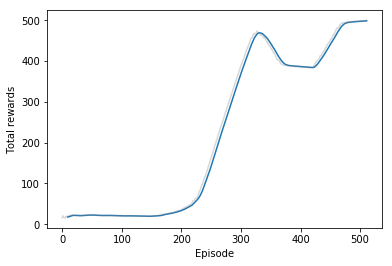

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

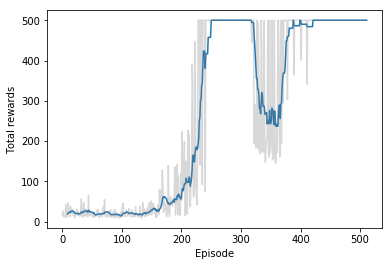

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

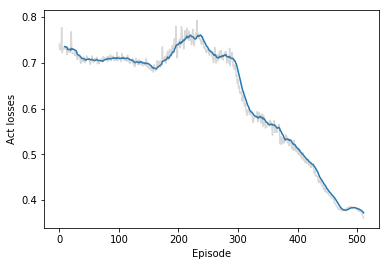

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

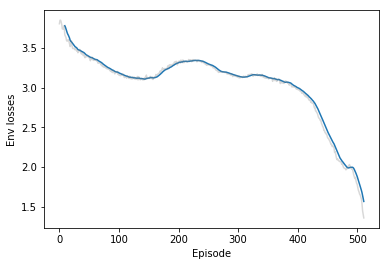

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

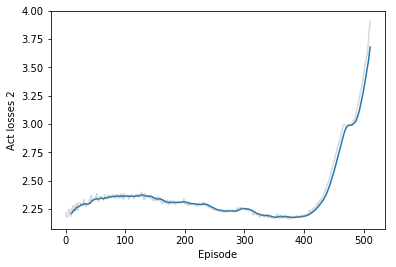

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
